# Presentation IMA205 Project Cardiac Disease Classification
This notebook presents the work done in an easy and clear way. The idea is that every step developed of the full stack can be presented and explained here.

In [27]:
# Importing the classes
import pandas as pd
import torch
import random
import torch.nn.functional as F
from densenet.densenet import DenseNet
from roi import ROI
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from densnet_trainer import DenseNetTrainer
from niidataloader import NiftiDataset
from feature_extractor import FeatureExtractor
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

## Introduction


The whole project has as north the paper: PONER EL NOMBRE DEL PAPER.
This papaer has multiple steps on its pipeline: First extract the Region Of Interest (ROI), this is the subimage where the left ventricle cavity, right vecntricle cavity and myocardium are. The output of the ROI step is a 128x128 image that will be later be segmented. The following code shows how the ROI extractor works.

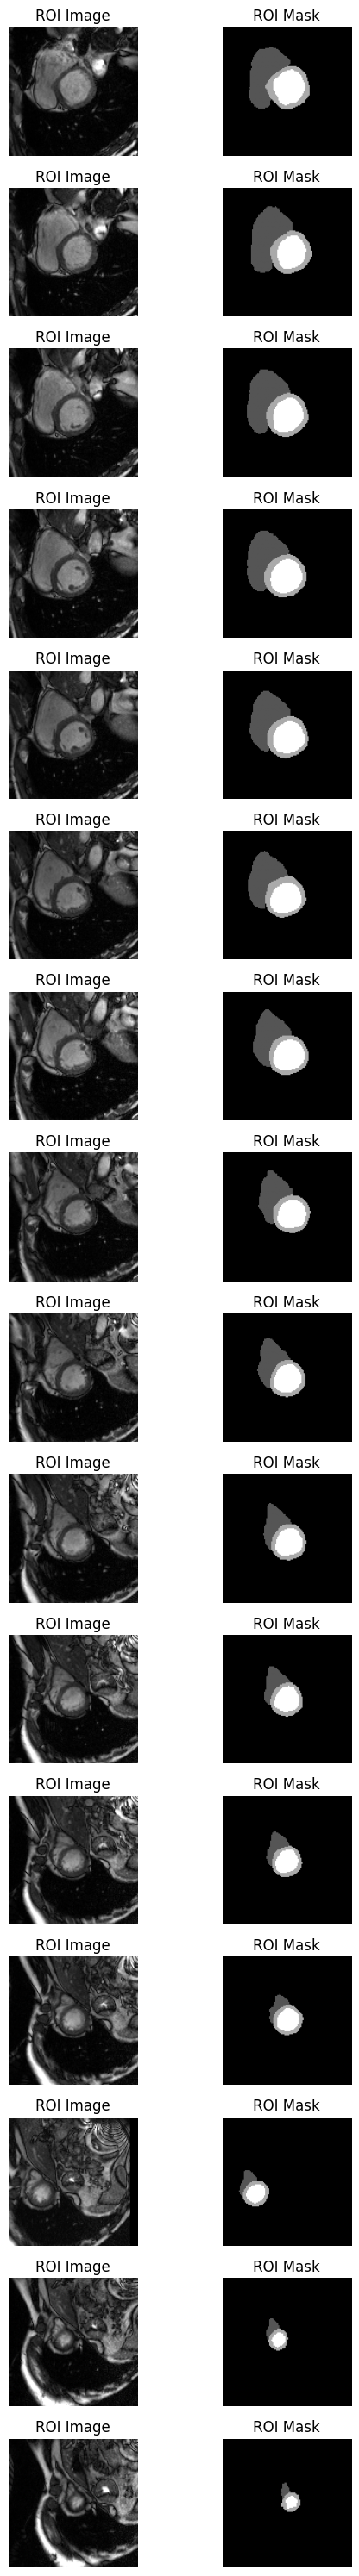

In [28]:
# plot the ROI images
# Load the dataset
roi_extractor = ROI('data/Train')
random.seed(42)
random_int = random.randint(0,100)
roi_image, roi_mask = roi_extractor.get_roi(random_int)
# Create a figure for everty slize in the image
fig, axs = plt.subplots(roi_image.shape[0], 2, figsize=(6, 30))
# Display the image and mask
for index in range(roi_image.shape[0]):
    axs[index, 0].imshow(roi_image[index], cmap='gray')
    axs[index, 1].imshow(roi_mask[index], cmap='gray')
    axs[index, 0].set_title('ROI Image')
    axs[index, 1].set_title('ROI Mask')
    axs[index, 0].axis('off')
    axs[index, 1].axis('off')
plt.tight_layout()
plt.show()



The NiftiDataset is the dataset that I made for this project, it loads the .nii images and returns a (4,220,220,num_slices) tensor. The first 4 correspond to the different images that we have from the same heart, the first one correspond to the end of diastolic phase, the second one to its mask (ground truth), the third one to the end of systolic phase and the last one to its mask.
This dataset have the option to augment the data (with the specifications provided in the paper) and output the ROI for each image (can be augmented as well). All of this was done in order to simplify the training of the densenet.

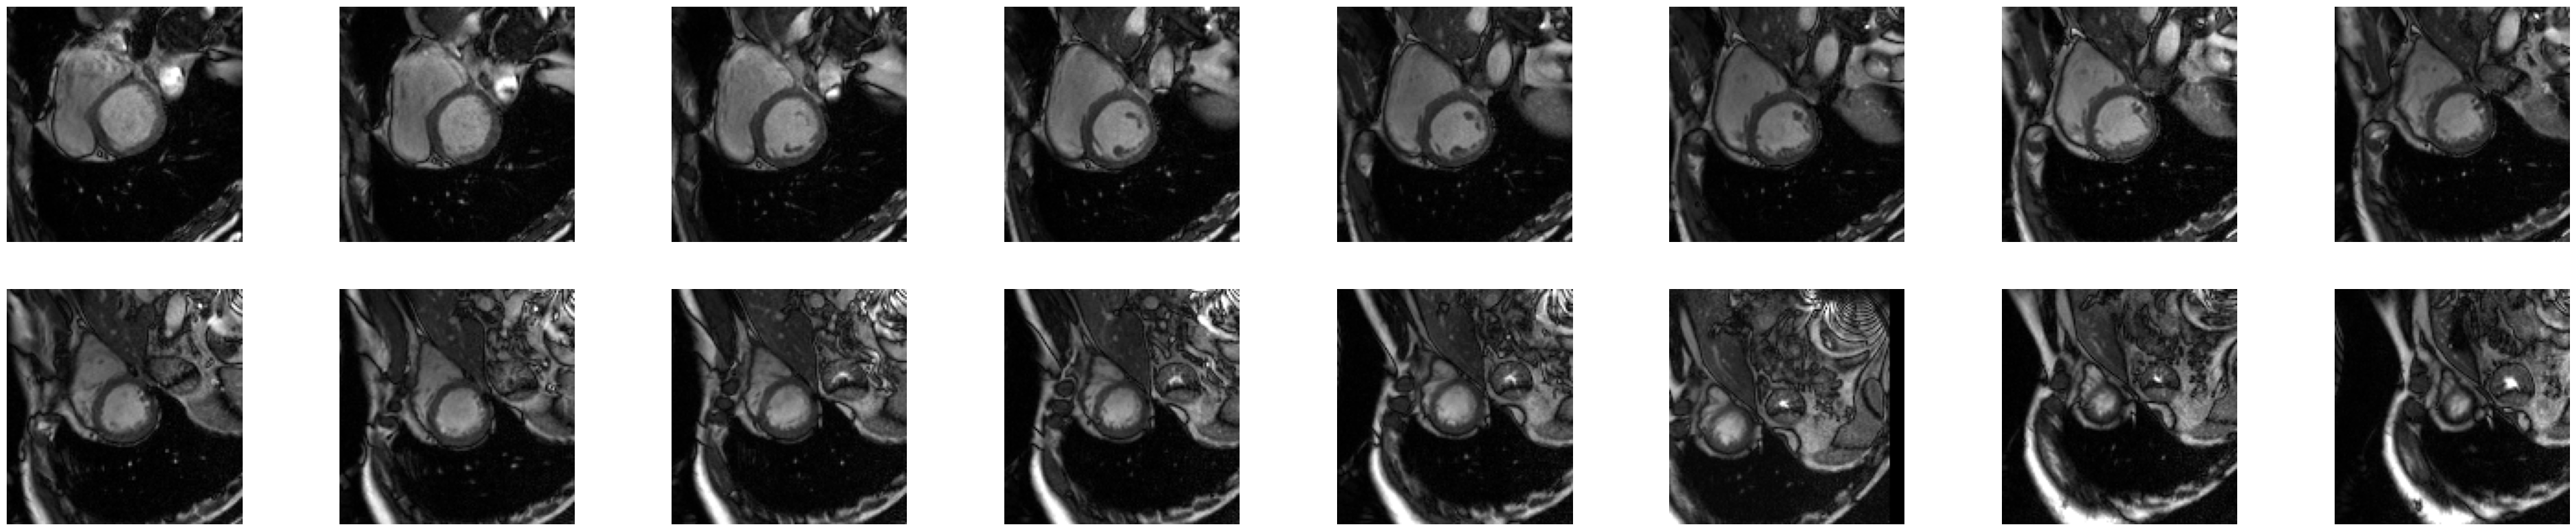

In [29]:
data_path = "./data/Train"
niftiidataset = NiftiDataset(image_path = data_path, roi=True, augment=False)
diastolic_loaded_image = niftiidataset[random_int][0]
amount_of_slices_over_2=int(roi_image.shape[0]/2)
fig, axs = plt.subplots(2,amount_of_slices_over_2, figsize=(50, 10))
for img_idx in range(diastolic_loaded_image.shape[-1]):
    img = diastolic_loaded_image[:,:,img_idx]
    img_idx_2 = int(img_idx%amount_of_slices_over_2)
    am_img=int(img_idx/amount_of_slices_over_2)
    axs[am_img,img_idx_2].imshow(img, cmap='gray')
    axs[am_img,img_idx_2].imshow(img, cmap='gray')
    axs[am_img,img_idx_2].axis('off')
    axs[am_img,img_idx_2].axis('off')


After having the image ROI image we will used the densenet described in the paper to segment it, and extract from there the left cavity, right cavity, miocardium and background.
There are two ways of doing this, you can either train the model from the begining or you can use my already trained model, the one that was sent with this work in a .pth file.

In [30]:
# IF set to true will train the model again. The training took me approximately two hours.
Train_model = False

device = torch.device("cuda")
work_dir = "/home/onyxia/work/project/CardiacPathologyPrediction/"

if Train_model:
    model = DenseNet()
    trainer = DenseNetTrainer(data_path)
    # The trainer configuration is like the one in the article
    trainer = DenseNetTrainer(data_path, epochs=200, alpha=0.25, train_fraction=0.8, check_val_every=10)
    trainer.train(model=model)
    model.eval()
else:
    # Load the Model
    model = DenseNet()
    # Load the model weights
    model.load_state_dict(torch.load(work_dir + 'model_weights_best_dice_val0.8000605702400208.pth')["model_state_dict"])
    model.to(device)
    model.eval()

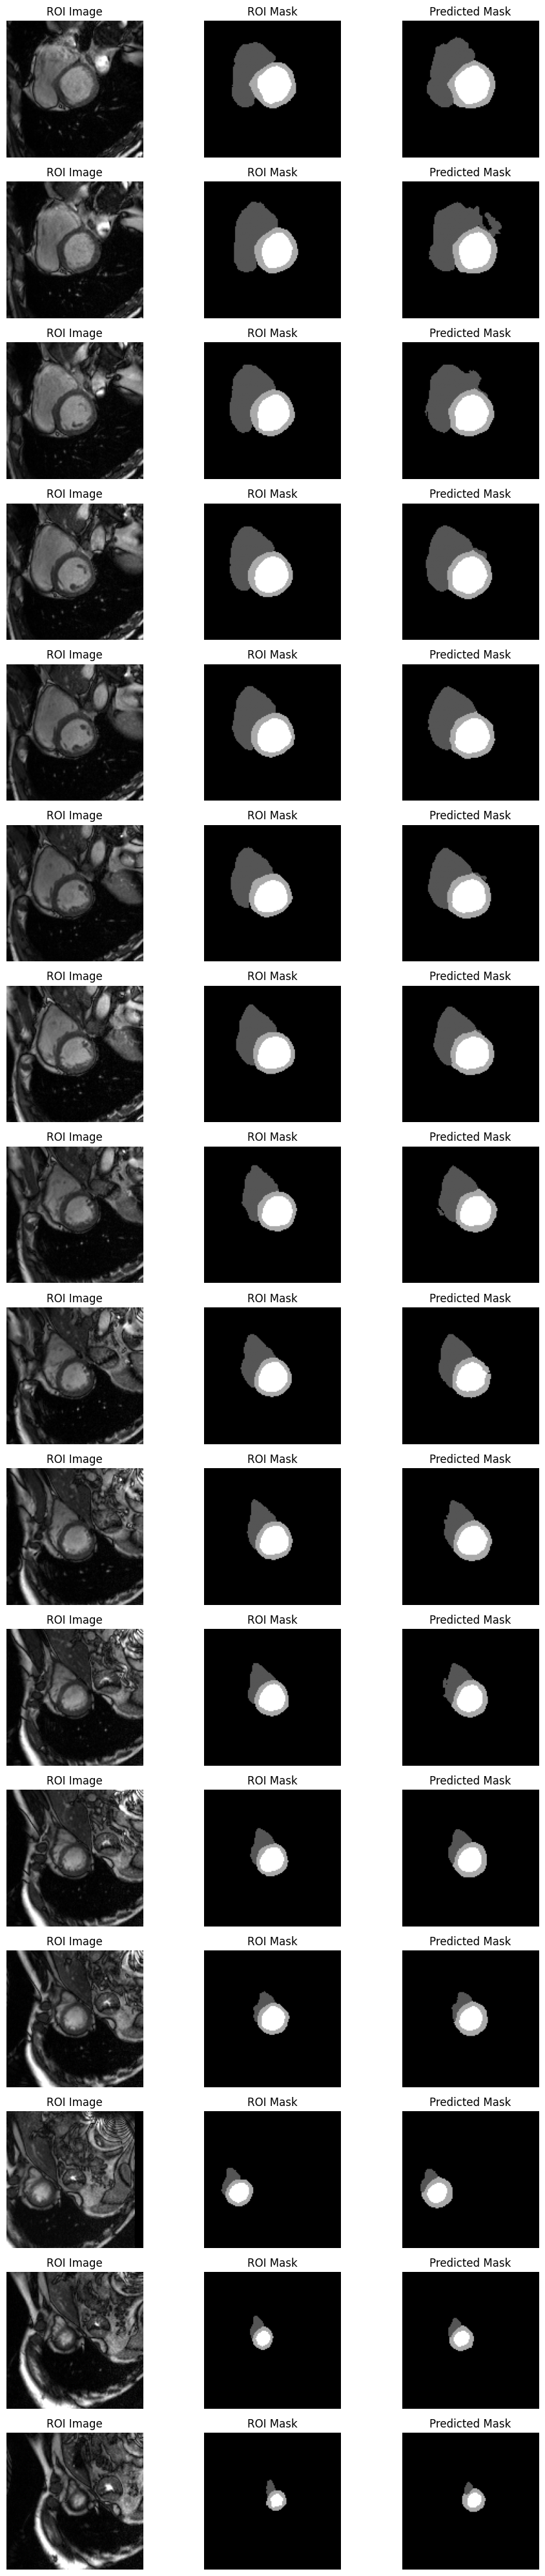

In [31]:
fig, axs = plt.subplots(roi_image.shape[0], 3, figsize=(10, 40))
# Display the image and mask
diastolic_loaded_image_mask = niftiidataset[random_int][1]
img = diastolic_loaded_image.to(torch.float32).permute(2,0,1)
img = img.unsqueeze(1)
img = img.to(device)
predicted_mask = model(img).squeeze(0).detach().cpu().numpy()
img = img.squeeze(1).detach().cpu().numpy()
predicted_mask = (predicted_mask>0.5)
predicted_mask[:,1] = model.get_largest_component(predicted_mask[:,1])
predicted_mask[:,2] = model.get_largest_component(predicted_mask[:,2])
predicted_mask[:,3] = model.get_largest_component(predicted_mask[:,3])

pred_mask = 0*predicted_mask[:,0] + 1*predicted_mask[:,1] + 2*predicted_mask[:,2] + 3*predicted_mask[:,3]
pred_mask = pred_mask/3
for img_idx in range(pred_mask.shape[0]):
    mask = diastolic_loaded_image_mask[:,:,img_idx]
    axs[img_idx, 0].imshow(img[img_idx], cmap='gray')
    axs[img_idx, 1].imshow(mask, cmap='gray')
    axs[img_idx, 2].imshow(pred_mask[img_idx], cmap='gray')
    axs[img_idx, 0].set_title('ROI Image')
    axs[img_idx, 1].set_title('ROI Mask')
    axs[img_idx, 2].set_title('Predicted Mask')
    axs[img_idx, 0].axis('off')
    axs[img_idx, 1].axis('off')
    axs[img_idx, 2].axis('off')
plt.tight_layout()
plt.show()

Now we will use the feature extraction model to extract the features from the 3D the features to use were extracted from the paper: PONER LOS PAPERS DE LAS FEATURES. A random tree is going to be trained after the extraction of the feaures.

## Classification

This subsection is going to be divided into three independent subsections:
- First a classification done only using the masks given.
- Then one using the segmentation model only in the left ventricle.
- Finally one using only the outputs of the segmentation model.

For now on we consider that the importance of a feature in the classification is related to the relation between the feature and the problem ( in this case the heart disease), thus we are not going to do the feature analysis step in every subsection but only in the first one, then the same features extracted in the first subsection will be used in the second and the third.

### Masks Only

In [6]:
df = pd.read_csv(work_dir + 'data/metaDataTrain.csv') 
# Show column names (to confirm names like 'Height' and 'Weight')
Heights = df['Height']
Weights = df['Weight']
gt_disease = df['Category']
nifti_train = NiftiDataset(image_path = work_dir + 'data/Train', roi=False, augment=False)

dataloader = DataLoader(nifti_train, batch_size=1, shuffle=False, num_workers=16) #This is a batchsize of 1 because the images are 3D
feature_extractor = FeatureExtractor()
features_tensors = []
for idx, img in tqdm(enumerate(dataloader), desc=f"Creating the dataset"):
    predicted_diastole = F.one_hot((img[0,1,:,:,:]*3).long(), num_classes=4).permute(2,3,0,1)
    predicted_systole = F.one_hot((img[0,3,:,:,:]*3).long(), num_classes=4).permute(2,3,0,1)
    
    predicted_systole_tensor = torch.cat((
        (predicted_systole[:,0]).unsqueeze(0),
        (predicted_systole[:,3]).unsqueeze(0),
        (predicted_systole[:,1]).unsqueeze(0),
        (predicted_systole[:,2]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    predicted_diastole_tensor = torch.cat((
        (predicted_diastole[:,0]).unsqueeze(0),
        (predicted_diastole[:,3]).unsqueeze(0),
        (predicted_diastole[:,1]).unsqueeze(0),
        (predicted_diastole[:,2]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    voxel_spacing = nifti_train.__get_spacing__(idx)

    features_tensor = feature_extractor.extract_features(
        predicted_diastole_tensor, 
        predicted_systole_tensor, 
        Heights[idx], 
        Weights[idx],
        voxel_spacing,
    )

    features_tensors.append(features_tensor)

gt_disease = [x for idx, x in enumerate(gt_disease) if features_tensors[idx][0]>1]
features_tensors = [x for x in features_tensors if x[0]>1]


Creating the dataset: 1it [00:00,  1.10it/s]

Creating the dataset: 100it [01:01,  1.62it/s]


In [7]:
feat_train, feat_test, label_train, label_test = train_test_split(
    features_tensors, 
    gt_disease, 
    test_size=0.3, 
    stratify=gt_disease,
    random_state=42
)

# Normalize the data
normalization = MinMaxScaler()
normalization.fit(feat_train)
feat_train = normalization.transform(feat_train)
feat_test = normalization.transform(feat_test)
print(np.unique(label_test))
print(np.unique(label_train))
print(feat_train[0])

[0 1 2 3 4]
[0 1 2 3 4]
[3.75851577e-01 2.00158386e-01 4.70530617e-01 3.27795859e-01
 2.31241871e-01 4.34315703e-01 5.37405456e-01 5.26565529e-01
 6.56253468e-02 2.98710537e-10 4.92249629e-02 8.93370196e-11
 2.38095238e-01 1.35135135e-01]


In [8]:
print("Start")

RF=RandomForestClassifier(class_weight='balanced', random_state=42)
p_grid_RF = {
    'n_estimators': [100,1000],# These were the two numbers proposed by the papers.
    # 'max_depth': [3,5,7], # The article expressed that the trees were grown to its full size.
    'min_samples_split': [4,10,15],
    'min_samples_leaf': [5,10],
}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=10, verbose=1)
grid_RF.fit(feat_train, label_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(feat_test,label_test))

Start
Fitting 10 folds for each of 12 candidates, totalling 120 fits


Best Validation Score: 0.9285714285714286
Best params: {'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 100}
Random Forest test score : 0.9333333333333333


As we can see, the outputs of the classification step are pretty promising, however, it could be interesting to do a feature analysis to try to reduce the amount of features extracted and get a better result. To do this I will extract the features with smallest importance and trying to get a better results with this subset of features. The random forest used for this porpuse is going to be the one with the best parameters found in the previous code, this because it will be hard to compute if a grid search was used.


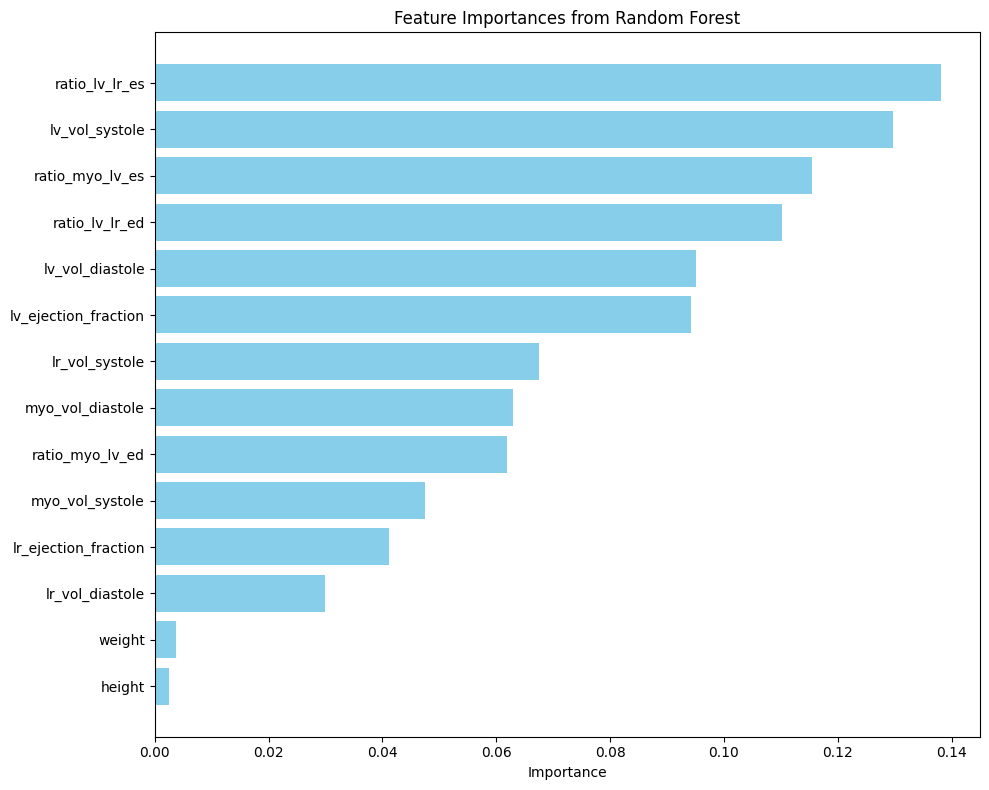

In [ ]:
RF=RandomForestClassifier(**grid_RF.best_params_, random_state=42)
RF.fit(feat_train, label_train)
# Features Importance
features = [
    "lv_vol_diastole", "lv_vol_systole", "lv_ejection_fraction",
    "lr_vol_diastole", "lr_vol_systole", "lr_ejection_fraction",
    "myo_vol_diastole", "myo_vol_systole",
    "ratio_lv_lr_ed", "ratio_lv_lr_es", "ratio_myo_lv_ed", "ratio_myo_lv_es",
    "height", "weight",
]

importances = RF.feature_importances_

# Create DataFrame for plotting
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()

As we can see there are multiple features that do not contribute almost at all to the classification. Like weight and height, so we are going to erase them them and train again in this smaller feature space.

In [10]:
# Get the indices that would sort the importances in descending order
sorted_indices = np.argsort(RF.feature_importances_)[::-1]

# Print the sorted indices and corresponding feature names (optional)
threshold_index = -1
for index, idx in enumerate(sorted_indices):
    print(f"Index: {idx}, Feature: {features[idx]}, Importance: {RF.feature_importances_[idx]:.4f}")
    if RF.feature_importances_[idx] < 0.05 and threshold_index==-1:
        threshold_index=index

print("The index threshold is: ", threshold_index)

Index: 9, Feature: ratio_lv_lr_es, Importance: 0.1381
Index: 1, Feature: lv_vol_systole, Importance: 0.1298
Index: 11, Feature: ratio_myo_lv_es, Importance: 0.1155
Index: 8, Feature: ratio_lv_lr_ed, Importance: 0.1102
Index: 0, Feature: lv_vol_diastole, Importance: 0.0951
Index: 2, Feature: lv_ejection_fraction, Importance: 0.0942
Index: 4, Feature: lr_vol_systole, Importance: 0.0674
Index: 6, Feature: myo_vol_diastole, Importance: 0.0630
Index: 10, Feature: ratio_myo_lv_ed, Importance: 0.0618
Index: 7, Feature: myo_vol_systole, Importance: 0.0476
Index: 5, Feature: lr_ejection_fraction, Importance: 0.0412
Index: 3, Feature: lr_vol_diastole, Importance: 0.0299
Index: 13, Feature: weight, Importance: 0.0038
Index: 12, Feature: height, Importance: 0.0025
The index threshold is:  9


I'm going to get rid of the features who's importance don't reach 0.005, to see if this improves the scores by reducing the noise.

In [11]:
feat_train2 = feat_train[:,sorted_indices[:threshold_index]]
feat_test2 = feat_test[:,sorted_indices[:threshold_index]]

In [12]:
print("Start")

RF2=RandomForestClassifier(class_weight='balanced', random_state=42, **grid_RF.best_params_)
RF2.fit(feat_train2, label_train)

print("Random Forest test score :",RF2.score(feat_test2,label_test))

Start
Random Forest test score : 0.9333333333333333


Now we test it in the test set from the beginning.

In [32]:
def plot_confusion_mat(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Class names
    class_names = [
        'Healthy controls',
        'Myocardial infarction',
        'Dilated cardiomyopathy',
        'Hypertrophic cardiomyopathy',
        'Abnormal right ventricle'
    ]
# 
    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


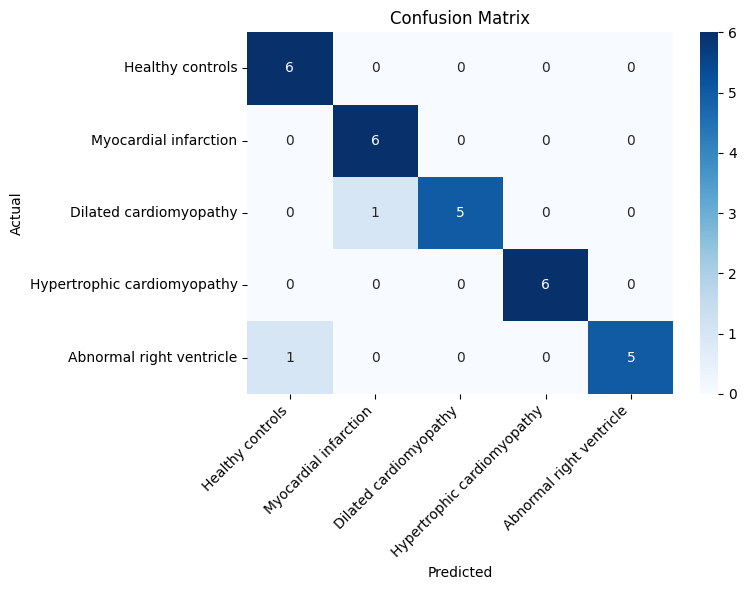

In [14]:
plot_confusion_mat(label_test, RF2.predict(feat_test2))

In [15]:
df = pd.read_csv(work_dir + 'data/metaDataTest.csv') 
# Show column names (to confirm names like 'Height' and 'Weight')
Heights = df['Height']
Weights = df['Weight']
nifti_test = NiftiDataset(image_path = work_dir + 'data/Test', roi=False, augment=False)

dataloader = DataLoader(nifti_test, batch_size=1, shuffle=False, num_workers=16) #This is a batchsize of 1 because the images are 3D
feature_extractor = FeatureExtractor()
features_tensors_test = []
for idx, img in tqdm(enumerate(dataloader), desc=f"Creating the dataset"):
    predicted_diastole = F.one_hot((img[0,1,:,:,:]*3).long(), num_classes=4).permute(2,3,0,1)
    predicted_systole = F.one_hot((img[0,3,:,:,:]*3).long(), num_classes=4).permute(2,3,0,1)

    # Reordering the features to match the feature extractor needs
    # (background, left ventricle, right ventricle, myocardium)
    predicted_systole_tensor = torch.cat((
        (predicted_systole[:,0]).unsqueeze(0),
        (predicted_systole[:,2]).unsqueeze(0),
        (predicted_systole[:,1]).unsqueeze(0),
        (predicted_systole[:,3]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    predicted_diastole_tensor = torch.cat((
        (predicted_diastole[:,0]).unsqueeze(0),
        (predicted_diastole[:,2]).unsqueeze(0),
        (predicted_diastole[:,1]).unsqueeze(0),
        (predicted_diastole[:,3]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    voxel_spacing = nifti_test.__get_spacing__(idx)

    features_tensor = feature_extractor.extract_features(
        predicted_diastole_tensor, 
        predicted_systole_tensor, 
        Heights[idx], 
        Weights[idx],
        voxel_spacing,
    )

    features_tensors_test.append(features_tensor)


Creating the dataset: 50it [00:37,  1.32it/s]


In [16]:
norm_features_tensors_test = normalization.transform(features_tensors_test)
features_tensors_test_small = norm_features_tensors_test[:,sorted_indices[:threshold_index]]
labels_test=RF2.predict(features_tensors_test_small)

In [17]:
labels_test

array([4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 3, 3, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 3, 4, 3, 4, 4,
       4, 4, 4, 4, 4, 4])

As we can see here, the classification without using the segmentation model is poor, this is due to the fact that in the test set there were no mask for the left ventricle thus some elements in the feature vector that the feature extractor class output were 0 or nan and those who depend on them have extreme values like e+10 after nor. This will be fixed with the segmentation model. Even thought we cannot see the ground truth of the test set, we assume that it will be close to 0.9 (like in the previous example).

In [18]:
features_tensors_test_small[3]

array([ 1.93027325e+01,  0.00000000e+00,  4.58415087e+00,  1.99678035e+10,
       -3.51176098e-03,             nan,  1.94856170e-01,  2.59252532e-01,
        6.06090473e+09])

In [19]:
print(np.unique(labels_test, return_counts=True))

(array([3, 4]), array([12, 38]))


## 

### Segmentation of the Left Ventricle Cavity only.

In [20]:
df = pd.read_csv(work_dir + 'data/metaDataTrain.csv')  # replace with your actual file path
# Show column names (to confirm names like 'Height' and 'Weight')
Heights = df['Height']
Weights = df['Weight']
gt_disease = df['Category']
data_path = 'data/Train'
nifti_train_lv = NiftiDataset(image_path = data_path, roi=True, augment=False) 
nifti_not_roi = NiftiDataset(image_path = data_path, roi=False, augment=False)
dataloader = DataLoader(nifti_train_lv, batch_size=1, shuffle=False, num_workers=8) #This is a batchsize of 1 because the images are 3D

feature_extractor = FeatureExtractor()
features_tensors = []

for idx, img in tqdm(enumerate(dataloader), desc=f"Creating the dataset"):
    diastole_image = img[0,0].unsqueeze(0).permute(3, 0, 1, 2).to(torch.float32)
    systole_image = img[0,2].unsqueeze(0).permute(3, 0, 1, 2).to(torch.float32)
    diastole_image = diastole_image.to(device)
    systole_image = systole_image.to(device)

    # Create the predicted masks to extract the Left Ventricle mask
    predicted_diastole = model(diastole_image).squeeze(0).detach().cpu()
    predicted_systole = model(systole_image).squeeze(0).detach().cpu()
    predicted_systole = (predicted_systole > 0.4)
    predicted_diastole = (predicted_diastole > 0.4)
    # print(predicted_systole.shape)
    
    # Compute padding sizes
    pad_height = 220 - 128
    pad_width = 220 - 128

    # Padding: (left, right, top, bottom)
    # F.pad expects the last dimensions first
    padding = (pad_width // 2, pad_width - pad_width // 2,
           pad_height // 2, pad_height - pad_height // 2)
    mask_lv_sys = F.pad(predicted_systole[:,3], padding, mode='constant', value=0).numpy()
    mask_lv_dias = F.pad(predicted_diastole[:,3], padding, mode='constant', value=0).numpy()
    
    # Get the actual mask
    img_2 = nifti_not_roi[idx].permute(3,0,1,2)

    mask_diastole = F.one_hot((img_2[:,1,:,:]*3).long().squeeze(0), num_classes=4).permute(0,3,1,2).numpy()
    mask_systole = F.one_hot((img_2[:,3,:,:]*3).long().squeeze(0), num_classes=4).permute(0,3,1,2).numpy()

    mask_lv_sys = model.get_largest_component(mask_lv_sys)
    mask_lv_dias = model.get_largest_component(mask_lv_dias)    

    # Reordering the features to match the feature extractor needs
    predicted_systole_tensor = torch.cat((
        torch.from_numpy(mask_systole[:,0]).unsqueeze(0), # Background
        torch.from_numpy(mask_lv_sys).unsqueeze(0), # Left Ventricle
        torch.from_numpy(mask_systole[:,1]).unsqueeze(0), # Right Ventricle
        torch.from_numpy(mask_systole[:,2]).unsqueeze(0), # Myocardium
    ), dim=0).permute(1,0,2,3)

    predicted_diastole_tensor = torch.cat((
        torch.from_numpy(mask_diastole[:,0]).unsqueeze(0),
        torch.from_numpy(mask_lv_dias).unsqueeze(0),
        torch.from_numpy(mask_diastole[:,1]).unsqueeze(0),
        torch.from_numpy(mask_diastole[:,2]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    voxel_spacing = nifti_not_roi.__get_spacing__(idx)

    features_tensor = feature_extractor.extract_features(
        predicted_diastole_tensor, 
        predicted_systole_tensor, 
        Heights[idx], 
        Weights[idx],
        voxel_spacing,
    )
    features_tensors.append(features_tensor)

# To avoid possible nan values
gt_disease = [x for idx, x in enumerate(gt_disease) if features_tensors[idx][0]>1]
features_tensors = [x for x in features_tensors if x[0]>1]


Creating the dataset: 0it [00:00, ?it/s]

Creating the dataset: 100it [04:30,  2.70s/it]


Start
Fitting 10 folds for each of 12 candidates, totalling 120 fits


Best Validation Score: 0.8714285714285716
Best params: {'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 100}
Random Forest test score : 0.8666666666666667


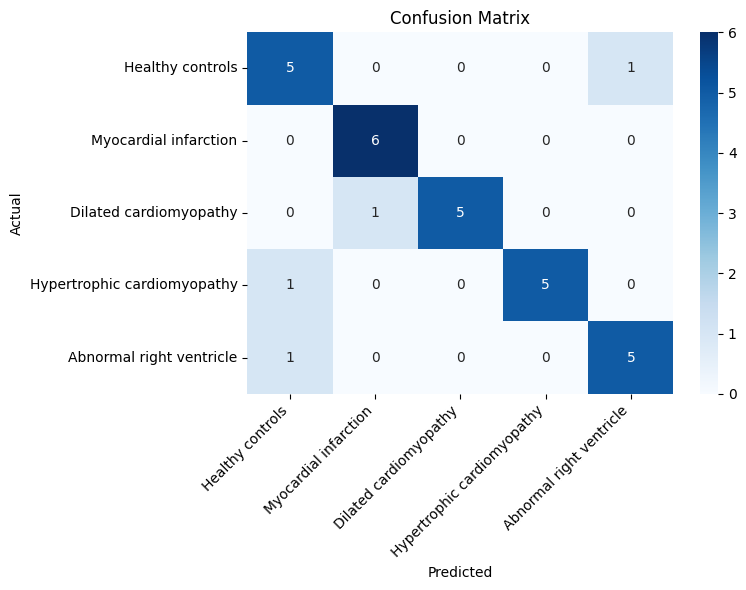

In [21]:
feat_train, feat_test, label_train, label_test = train_test_split(
    features_tensors, 
    gt_disease, 
    test_size=0.3, 
    stratify=gt_disease,
    random_state=42
)

# Normalize the data
normalization = MinMaxScaler()
normalization.fit(feat_train)
feat_train = normalization.transform(feat_train)
feat_test = normalization.transform(feat_test)

print("Start")

RF=RandomForestClassifier(class_weight='balanced', random_state=42)
p_grid_RF = {
    'n_estimators': [100,1000],# These were the two numbers proposed by the papers.
    # 'max_depth': [3,5,7],
    'min_samples_split': [4,10,15],
    'min_samples_leaf': [5,10],
}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=10, verbose=1)
grid_RF.fit(feat_train, label_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(feat_test,label_test))
plot_confusion_mat(label_test, grid_RF.predict(feat_test))

Creating the dataset: 0it [00:00, ?it/s]

Creating the dataset: 10it [00:53,  2.57s/it]

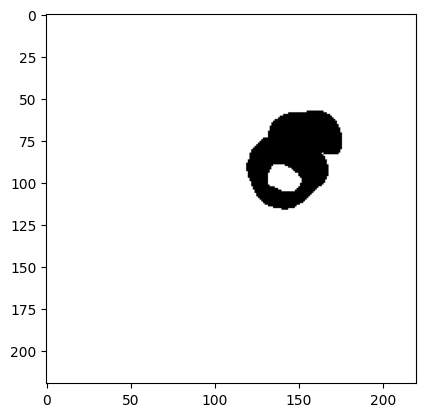

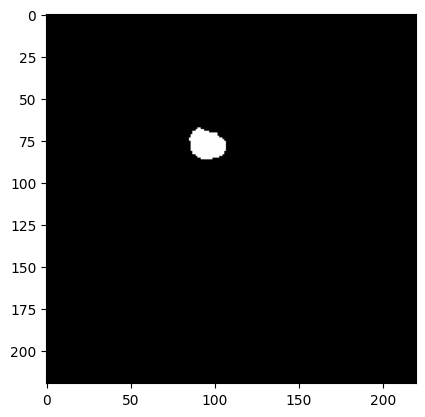

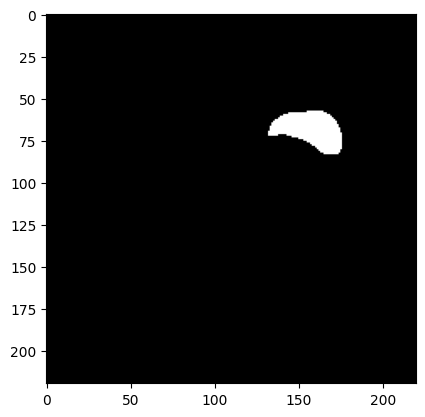

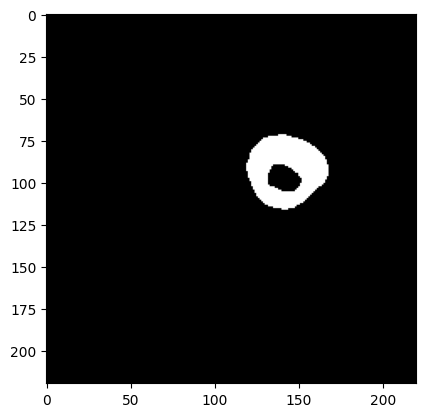

Creating the dataset: 50it [02:20,  2.81s/it]


In [22]:
df = pd.read_csv('/home/onyxia/work/project/CardiacPathologyPrediction/data/metaDataTest.csv')  # replace with your actual file path
# Show column names (to confirm names like 'Height' and 'Weight')
Heights = df['Height']
Weights = df['Weight']
data_path = "./data/Test"
niftiidatasettest = NiftiDataset(image_path = data_path, roi=True, augment=False)
nifti_not_roi = NiftiDataset(image_path = data_path, roi=False, augment=False) 

dataloadertest = DataLoader(niftiidatasettest, batch_size=1, shuffle=False, num_workers=16) #This is a batchsize of 1 because the images are 3D
feature_extractor_test = FeatureExtractor()
features_tensors_test = []

for idx, img in tqdm(enumerate(dataloadertest), desc=f"Creating the dataset"):
    diastole_image = img[0,0].unsqueeze(0).permute(3, 0, 1, 2).to(torch.float32)
    systole_image = img[0,2].unsqueeze(0).permute(3, 0, 1, 2).to(torch.float32)
    diastole_image = diastole_image.to(device)
    systole_image = systole_image.to(device)

    # Create the predicted masks to extract the Left Ventricle mask
    predicted_diastole = model(diastole_image).squeeze(0).detach().cpu()
    predicted_systole = model(systole_image).squeeze(0).detach().cpu()
    predicted_systole = (predicted_systole > 0.5)
    predicted_diastole = (predicted_diastole > 0.5)

    # Get the actual mask
    img_2 = nifti_not_roi[idx].permute(3,0,1,2)
    mask_diastole = F.one_hot((img_2[:,1,:,:]*3).long(), num_classes=4).permute(0,3,1,2).numpy()
    mask_systole = F.one_hot((img_2[:,3,:,:]*3).long(), num_classes=4).permute(0,3,1,2).numpy()

    pad_height = 220 - 128
    pad_width = 220 - 128

    # Padding: (left, right, top, bottom)
    # F.pad expects the last dimensions first
    padding = (pad_width // 2, pad_width - pad_width // 2,
           pad_height // 2, pad_height - pad_height // 2)
    mask_lv_sys = F.pad(predicted_systole[:,3], padding, mode='constant', value=0).numpy()
    mask_lv_dias = F.pad(predicted_diastole[:,3], padding, mode='constant', value=0).numpy()

    mask_lv_sys = model.get_largest_component(mask_lv_sys)
    mask_lv_dias = model.get_largest_component(mask_lv_dias)

    # Reordering the features to match the feature extractor needs
    if idx==10:
        plt.imshow(mask_systole[3,0], cmap='grey')
        plt.show()
        plt.imshow(mask_lv_sys[3], cmap='grey')
        plt.show()
        plt.imshow(mask_systole[3,1], cmap='grey')
        plt.show()
        plt.imshow(mask_systole[3,3], cmap='grey')
        plt.show()
        # break
    predicted_systole_tensor = torch.cat((
        torch.from_numpy(mask_systole[:,0]).unsqueeze(0), # Background
        torch.from_numpy(mask_lv_sys).unsqueeze(0), # Left Ventricle
        torch.from_numpy(mask_systole[:,1]).unsqueeze(0), # Right Ventricle
        torch.from_numpy(mask_systole[:,3]).unsqueeze(0), # Myocardium
    ), dim=0).permute(1,0,2,3)

    predicted_diastole_tensor = torch.cat((
        torch.from_numpy(mask_diastole[:,0]).unsqueeze(0),
        torch.from_numpy(mask_lv_dias).unsqueeze(0),
        torch.from_numpy(mask_diastole[:,1]).unsqueeze(0),
        torch.from_numpy(mask_diastole[:,3]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    voxel_spacing = nifti_not_roi.__get_spacing__(idx)

    features_tensor = feature_extractor.extract_features(
        predicted_diastole_tensor, 
        predicted_systole_tensor, 
        Heights[idx], 
        Weights[idx],
        
        

        
    )
    features_tensors_test.append(features_tensor)

In [ ]:
norm_features_tensors_test = normalization.transform(features_tensors_test)
labels_test=grid_RF.predict(norm_features_tensors_test)
labels_test

array([0, 4, 0, 0, 4, 3, 4, 2, 1, 0, 3, 2, 1, 4, 3, 2, 4, 4, 4, 1, 0, 2,
       0, 1, 3, 2, 4, 0, 3, 0, 0, 1, 2, 3, 2, 3, 3, 2, 0, 3, 1, 2, 3, 0,
       1, 4, 2, 4, 1, 4])

In [24]:
print(np.unique(labels_test, return_counts=True))

(array([0, 1, 2, 3, 4]), array([11,  8, 10, 10, 11]))


In [25]:
norm_features_tensors_test[0]

array([0.31729843, 0.16849971, 0.80826443, 0.40936151, 0.24642341,
       0.53360711, 0.3328441 , 0.39853058, 0.1674107 , 0.13806981,
       0.1110289 , 0.32225844, 0.47619048, 0.28378378])

As we can see in the output of the test set, there are still variables that are not taken into consideration, this is probably because the left ventricle mask was extracted from a different model than the other masks, thus the size and other aspects of it are still a little off. To fix this I'm going to implement the whole stack but using only the DenseNet model. 

**Note:** The reason because this probably didn't happen with the test set inside the train set is because the segmentation model was train in this data, thus the model probably performs better in it and is able to segment the better leading to a better result. 

### Use the Output of the DenseNet for Segmentation

In [38]:
df = pd.read_csv(work_dir + 'data/metaDataTrain.csv')  # replace with your actual file path
# Show column names (to confirm names like 'Height' and 'Weight')
Heights = df['Height']
Weights = df['Weight']
data_path = 'data/Train'
gt_disease = df['Category']
nifti_train_full = NiftiDataset(image_path = data_path, roi=True, augment=False) 
dataloader = DataLoader(nifti_train_full, batch_size=1, shuffle=False, num_workers=16) #This is a batchsize of 1 because the images are 3D


feature_extractor = FeatureExtractor()
features_tensors = []

for idx, img in tqdm(enumerate(dataloader), desc=f"Creating the dataset"):
    diastole_image = img[0,0].unsqueeze(0).permute(3, 0, 1, 2).to(torch.float32)
    systole_image = img[0,2].unsqueeze(0).permute(3, 0, 1, 2).to(torch.float32)
    diastole_image = diastole_image.to(device)
    systole_image = systole_image.to(device)

    # Create the predicted masks to extract the Left Ventricle mask
    predicted_diastole = model(diastole_image).squeeze(0).detach().cpu()
    predicted_systole = model(systole_image).squeeze(0).detach().cpu()
    predicted_systole = (predicted_systole > 0.5).numpy()
    predicted_diastole = (predicted_diastole > 0.5).numpy()

    predicted_diastole[:,1] = model.get_largest_component(predicted_diastole[:,1])
    predicted_diastole[:,2] = model.get_largest_component(predicted_diastole[:,2])
    predicted_diastole[:,3] = model.get_largest_component(predicted_diastole[:,3])

    predicted_systole[:,1] = model.get_largest_component(predicted_systole[:,1])
    predicted_systole[:,2] = model.get_largest_component(predicted_systole[:,2])
    predicted_systole[:,3] = model.get_largest_component(predicted_systole[:,3

    # Reordering the features to match the feature extractor needs
    predicted_systole_tensor = torch.cat((
        torch.from_numpy(predicted_systole[:,0]).unsqueeze(0), # Background
        torch.from_numpy(predicted_systole[:,3]).unsqueeze(0), # Left Ventricle
        torch.from_numpy(predicted_systole[:,1]).unsqueeze(0), # Right Ventricle
        torch.from_numpy(predicted_systole[:,2]).unsqueeze(0), # Myocardium
    ), dim=0).permute(1,0,2,3)

    predicted_diastole_tensor = torch.cat((
        torch.from_numpy(predicted_diastole[:,0]).unsqueeze(0),
        torch.from_numpy(predicted_diastole[:,3]).unsqueeze(0),
        torch.from_numpy(predicted_diastole[:,1]).unsqueeze(0),
        torch.from_numpy(predicted_diastole[:,2]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    voxel_spacing = nifti_train_full.__get_spacing__(idx)

    features_tensor = feature_extractor.extract_features(
        predicted_diastole_tensor, 
        predicted_systole_tensor, 
        Heights[idx], 
        Weights[idx],
        voxel_spacing,
    )
    features_tensors.append(features_tensor)


# To avoid possible nan values
gt_disease = [x for idx, x in enumerate(gt_disease) if features_tensors[idx][0]>1]
features_tensors = [x for x in features_tensors if x[0]>1]

Creating the dataset: 100it [03:21,  2.01s/it]


In [40]:
feat_train, feat_test, label_train, label_test = train_test_split(
    features_tensors, 
    gt_disease, 
    test_size=0.3, 
    stratify=gt_disease,
    random_state=42
)

# Normalize the data
normalization = MinMaxScaler()
normalization.fit(feat_train)
feat_train = normalization.transform(feat_train)
feat_test = normalization.transform(feat_test)
print(np.unique(label_test))
print(np.unique(label_train))
print(feat_train[0])

[0 1 2 3 4]
[0 1 2 3 4]
[0.29712997 0.16065513 0.79428168 0.2612828  0.30238056 0.3523133
 0.29990185 0.23626376 0.08171831 0.1742297  0.09535636 0.13976555
 0.23809524 0.13513514]


Start
Fitting 10 folds for each of 36 candidates, totalling 360 fits


Best Validation Score: 0.8571428571428573
Best params: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 1000}
Random Forest test score : 0.8


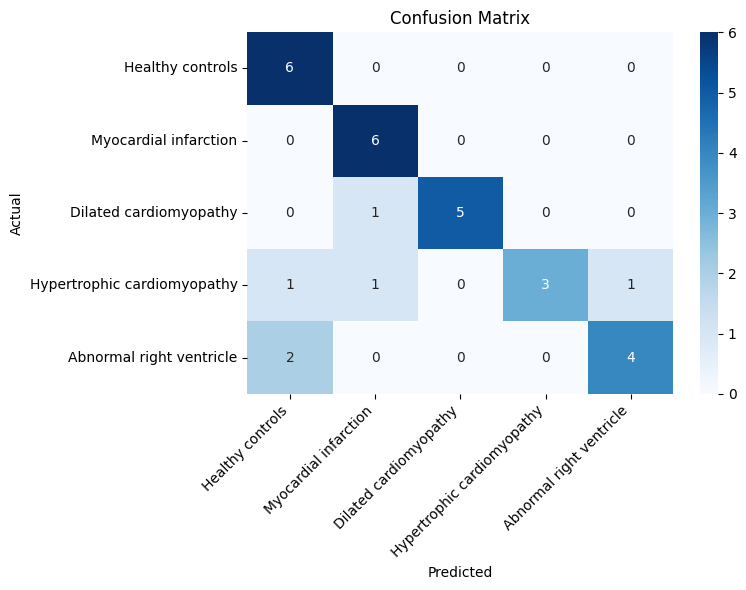

In [41]:
print("Start")

RF=RandomForestClassifier(random_state=42)

p_grid_RF = {
    'n_estimators': [100,1000],# These were the two numbers proposed by the papers.
    'max_depth': [3,5,7], # Here the RF was overfitting a little so I decided to add this
    'min_samples_split': [4,10,15],
    'min_samples_leaf': [5,10],
}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=10, verbose=1)
grid_RF.fit(feat_train, label_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(feat_test,label_test))
plot_confusion_mat(label_test, grid_RF.predi))

In [42]:
df = pd.read_csv(work_dir + 'data/metaDataTest.csv')  # replace with your actual file path
# Show column names (to confirm names like 'Height' and 'Weight')
Heights = df['Height']
Weights = df['Weight']
data_path = 'data/Test'
nifti_test_full = NiftiDataset(image_path = data_path, roi=True, augment=False) 
dataloader = DataLoader(nifti_test_full, batch_size=1, shuffle=False, num_workers=16) #This is a batchsize of 1 because the images are 3D


feature_extractor = FeatureExtractor()
features_tensors_test = []

for idx, img in tqdm(enumerate(dataloader), desc=f"Creating the dataset"):
    diastole_image = img[0,0].unsqueeze(0).permute(3, 0, 1, 2).to(torch.float32)
    systole_image = img[0,2].unsqueeze(0).permute(3, 0, 1, 2).to(torch.float32)
    diastole_image = diastole_image.to(device)
    systole_image = systole_image.to(device)

    # Create the predicted masks to extract the Left Ventricle mask
    predicted_diastole = model(diastole_image).squeeze(0).detach().cpu()
    predicted_systole = model(systole_image).squeeze(0).detach().cpu()
    predicted_systole = (predicted_systole > 0.5).numpy()
    predicted_diastole = (predicted_diastole > 0.5).numpy()

    predicted_diastole[:,1] = model.get_largest_component(predicted_diastole[:,1])
    predicted_diastole[:,2] = model.get_largest_component(predicted_diastole[:,2])
    predicted_diastole[:,3] = model.get_largest_component(predicted_diastole[:,3])

    predicted_systole[:,1] = model.get_largest_component(predicted_systole[:,1])
    predicted_systole[:,2] = model.get_largest_component(predicted_systole[:,2])
    predicted_systole[:,3] = model.get_largest_component(predicted_systole[:,3])

    # Reordering the features to match the feature extractor needs
    predicted_systole_tensor = torch.cat((
        torch.from_numpy(predicted_systole[:,0]).unsqueeze(0), # Background
        torch.from_numpy(predicted_systole[:,3]).unsqueeze(0), # Left Ventricle
        torch.from_numpy(predicted_systole[:,1]).unsqueeze(0), # Right Ventricle
        torch.from_numpy(predicted_systole[:,2]).unsqueeze(0), # Myocardium
    ), dim=0).permute(1,0,2,3)

    predicted_diastole_tensor = torch.cat((
        torch.from_numpy(predicted_diastole[:,0]).unsqueeze(0),
        torch.from_numpy(predicted_diastole[:,3]).unsqueeze(0),
        torch.from_numpy(predicted_diastole[:,1]).unsqueeze(0),
        torch.from_numpy(predicted_diastole[:,2]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    voxel_spacing = nifti_test_full.__get_spacing__(idx)

    features_tensor_test = feature_extractor.extract_features(
        predicted_diastole_tensor, 
        predicted_systole_tensor, 
        Heights[idx], 
        Weights[idx],
        voxel_spacing,
    )
    features_tensors_test.append(features_tensor_test)

Creating the dataset: 50it [01:56,  2.33s/it]


In [43]:
norm_features_tensors_test = normalization.transform(features_tensors_test)
labels_test=grid_RF.predict(norm_features_tensors_test)
labels_test

array([0, 4, 3, 0, 1, 4, 4, 2, 1, 0, 3, 2, 1, 4, 0, 2, 4, 4, 4, 2, 0, 2,
       4, 1, 3, 2, 4, 0, 3, 4, 3, 1, 2, 3, 2, 3, 3, 2, 0, 3, 1, 2, 3, 0,
       1, 4, 2, 4, 1, 4])

In [44]:
print(np.unique(labels_test, return_counts=True))



(array([0, 1, 2, 3, 4]), array([ 8,  8, 11, 10, 13]))


As we can see in this output, in this last case every single class is predicted in the test set (thing that didn't happen before). Even thought we cannot know for sure if this prediction will be better than the previous ones, I have the intuition that in the test set there where examples of every class thus this prediction is probably better than the previous ones.

### Save Test Values

In [ ]:
import csv

# Open a new CSV file
with open('results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write header
    writer.writerow(['Id', 'Category'])
    
    # Write index and value
    for idx, num in enumerate(labels_test):
        writer.writerow([idx+101, num])
